In [1]:
import tensorflow as tf
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPool2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from coclust.evaluation.external import accuracy
from sklearn import mixture
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/sanidhya/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
x_train1 = x_train.reshape(len(x_train),-1)
x_test1 = x_test.reshape(len(x_test),-1)

x_train1 = x_train1.astype(float) / 255
x_test1 = x_test1.astype(float) / 255

In [ ]:
kmeans = KMeans(init = "random", n_clusters=10,random_state=5, max_iter = 27)
kmeans.fit(x_train1)
y_pred1 = kmeans.predict(x_test1)

In [ ]:
cm = confusion_matrix(y_test, y_pred1)
print(cm)

In [ ]:
accuracy(y_test, y_pred1)

In [ ]:
#Part 2: Auto-Encoder with KMeans clustering

In [3]:
x_train2 = x_train.reshape(-1, 28,28, 1)
x_test2 = x_test.reshape(-1, 28,28, 1)

x_train2 = x_train2.astype(float) / 255
x_test2 = x_test2.astype(float) / 255

In [4]:
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='sgd', loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 14)        140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 7)         889       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 7)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 7)          

In [5]:
epochs = 10
graph = model.fit(x_train2, x_train2, epochs=10, batch_size=256, validation_data=(x_test2, x_test2), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 528us/step - loss: 0.1007 - val_loss: 0.0653
Epoch 2/10
60000/60000 [==============================] - 32s 530us/step - loss: 0.0585 - val_loss: 0.0616
Epoch 3/10
60000/60000 [==============================] - 32s 538us/step - loss: 0.0540 - val_loss: 0.0599
Epoch 4/10
60000/60000 [==============================] - 32s 540us/step - loss: 0.0518 - val_loss: 0.0589
Epoch 5/10
60000/60000 [==============================] - 32s 539us/step - loss: 0.0501 - val_loss: 0.0568
Epoch 6/10
60000/60000 [==============================] - 33s 554us/step - loss: 0.0487 - val_loss: 0.0560
Epoch 7/10
60000/60000 [==============================] - 33s 546us/step - loss: 0.0477 - val_loss: 0.0535
Epoch 8/10
60000/60000 [==============================] - 33s 554us/step - loss: 0.0468 - val_loss: 0.0525
Epoch 9/10
60000/60000 [==============================] - 33s 554us/step - loss: 0.0461 - val_

In [6]:
restored_testing_dataset = model.predict(x_test2)
encoder = K.function([model.layers[0].input], [model.layers[4].output])
encoded_images = encoder([x_test2])[0].reshape(-1,7*7*7)

In [7]:
kmeans = KMeans(n_clusters=10, max_iter = 29, init = "random", random_state=5)
clustered_training_set = kmeans.fit_predict(encoded_images)

In [8]:
from coclust.evaluation.external import accuracy

accuracy(y_test, clustered_training_set)

/Users/sanidhya/Anaconda/anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


0.5446

In [9]:
cm = confusion_matrix(y_test, clustered_training_set)
print(cm)

[[538   3   1   0  41  73   6  29 104 205]
 [  2   0   0   0  10  13   1 843 119  12]
 [  7   3   0   0 577  53   3   5  27 325]
 [ 13   2   0   0  14  70   2 451 387  61]
 [  1   6   0   0 645  39   2  18 163 126]
 [  0   2 275 122   0 596   1   1   0   3]
 [ 99   1   0   0 336 107  15  21 109 312]
 [  0   0 880  35   0  85   0   0   0   0]
 [  1 416  32   1  65  73 395   5   3   9]
 [  0   2 157 801   2  31   1   1   4   1]]


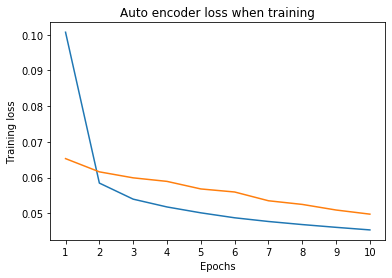

In [11]:
epoch=range(1,epochs+1)
plt.plot(epoch,graph.history['loss'])
plt.plot(epoch,graph.history['val_loss'])
plt.xticks(epoch, rotation ='horizontal')
plt.title('Auto encoder loss when training')
plt.ylabel('Training loss')
plt.xlabel('Epochs')
plt.show()

In [ ]:
#Part 3: Auto-Encoder with GMM Clustering

In [ ]:
gmm = mixture.GaussianMixture(n_components = 10, max_iter = 28)
clustered_training_set = gmm.fit_predict(encoded_images)
cm = confusion_matrix(y_test, clustered_training_set)
print(cm)

In [ ]:
from coclust.evaluation.external import accuracy

accuracy(y_test, clustered_training_set)